<a href="https://colab.research.google.com/github/Miyukii/Titanic-pi/blob/main/Titanic_pi_principal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O Titanic challenge é uma competição do Kaggle em que o objetivo é prever o passageiro que sobrevive ou morre baseado em uma série de variáveis como idade, sexo, tipo da passagem, etc.

Este notebook é baseado no notebook do ahmedbasbas e objetivo é atingir um score de 0.8134. Com esse score é possível estar entre os 5% melhores do Kaggle.

Iniciaremos com uma fase de *exploratory data analysis* (EDA), após isso faremos a *feature engineering* e finalmente faremos o modelo preditivo.

As principais bibliotecas a serem utilizadas serão:

* **Pandas** para manipulação e ingestão dos dados.
* **Matplotlib** e **seaborn** para visualização dos dados.
* **Numpy** para computação de arrays multidimensionais.
* **sklearn** para machine learning e modelagem preditiva.

## Ambiente

São 3 opções:


* instalar o jupyter na sua máquina.
* Utilizar o notebook no próprio Kaggle
* Utilizar o colab do google.

# I - Exploratory data analysis (EDA)

Um projeto de data science sempre se inicia com uma análise cuidadosa dos dados e construção das primeiras impressões.

Nesta sessão n's faremos quatro coisas: 

In [ ]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

Agora vamos importar as bibliotecas que serão úteis.

In [ ]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import pylab as plot
params = {
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

Para esse problema, o Kaggle oferece dois datasets: um de treinamento e um de teste. Nós vamos usar o de treinamento para construir nosso modelo preditivo e o de teste para avalia-lo e gerar um arquivo de saída para submeter para o sistema de avaliação do Kaggle.

Vamos começar carregando a base de treinamento. Primeiro faça o download da base de treinamento no Kaggle .

Agora vamos subir o arquivo de treinamento para o notebook.

Existem 3 boas formas de fazer isso :

Abrir direto do github (arquivos até 25MB)
Fazer upload da sua máquina.
Acessar um arquivo do seu google drive.
Vamos optar pelo upload.

In [ ]:
from google.colab import files
# upload do arquivo de treinamento (train.csv)
uploaded = files.upload()

Saving train.csv to train (1).csv
Saving test.csv to test (1).csv


In [ ]:
import io
data = pd.read_csv(io.BytesIO(uploaded['train.csv']))

In [ ]:
print(data.shape)

(891, 12)


Se tudo deu certo, pode ver que temos:
* 891 linhas
* 12 colunas

O Pandas permite que você dê uma olhada nos dados ...

In [ ]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


A coluna Survived é a variável alvo, aquela que queremos prever. Se Survided=1 o passageiro sobreviveu, caso contrário ele morreu.

As outras variáveis descrevem os passageiros, são elas que chamamos de features.

* PassengerId: Id de cada passageiro no barco.
* Pclass: a classe do passageiro. Existem 3 valores possíveis: 1,2 e 3 (Primeira, segunda e terceira classe)
* Name: nome
* Sex: sexo
* Age: idade
* SibSp: quantidade de irmãos e conjuge (Siblings e spouses) viajando com o passageiro.
* Parch: quantidade de pais e filhos viajando com o passageiro
* The ticket number: numero do bilhete
* The ticket Fare: tarifa do bilhete
* The cabin number: número da cabine
* The embarkation: O Titanic tinha três portos possíveis de embarque: C = Cherbourg, Q = Queenstown, S = Southampton

Com o Pandas é possível ter uma visão geral através de dados estísticos simples da features numéricas. Basta usar o método describe.

In [ ]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Repare a variável "Age", ela demonstra que 177 linhas estão faltando valores.
Uma solução é preencher os valores nulos com a mediana das idades.
Nós podemos também preencher com a média das idades, no entanto a mediana é mais robusta aos outliers.

*Lembrando*: A média é a média aritmética de um conjunto de números. A mediana é um valor numérico que separa a metade superior de um conjunto da metade inferior.

In [ ]:
data['Age'] = data['Age'].fillna(data['Age'].median())

Vamos verificar o resultado:

In [ ]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Perfeito.

Agora vamos criar alguns gráficos.

Vamos visualizar a sobrevivência em relação ao gênero. Para facilitar vamos criar a coluna "Died" que representa aqueles que morreram.

In [ ]:
data['Died'] = 1 - data['Survived']
# data.head()

Agora vamos criar um gráfico que mostra os dados agrupados por sexo e empilha as barras, de forma que mulheres e homens forme uma barra e parte da barra seja os que sobreviveram e parte seja os que morreram. Para melhorar a visualização vamos colorir os que morreram de vermelho e os que sobreviveram de verde.

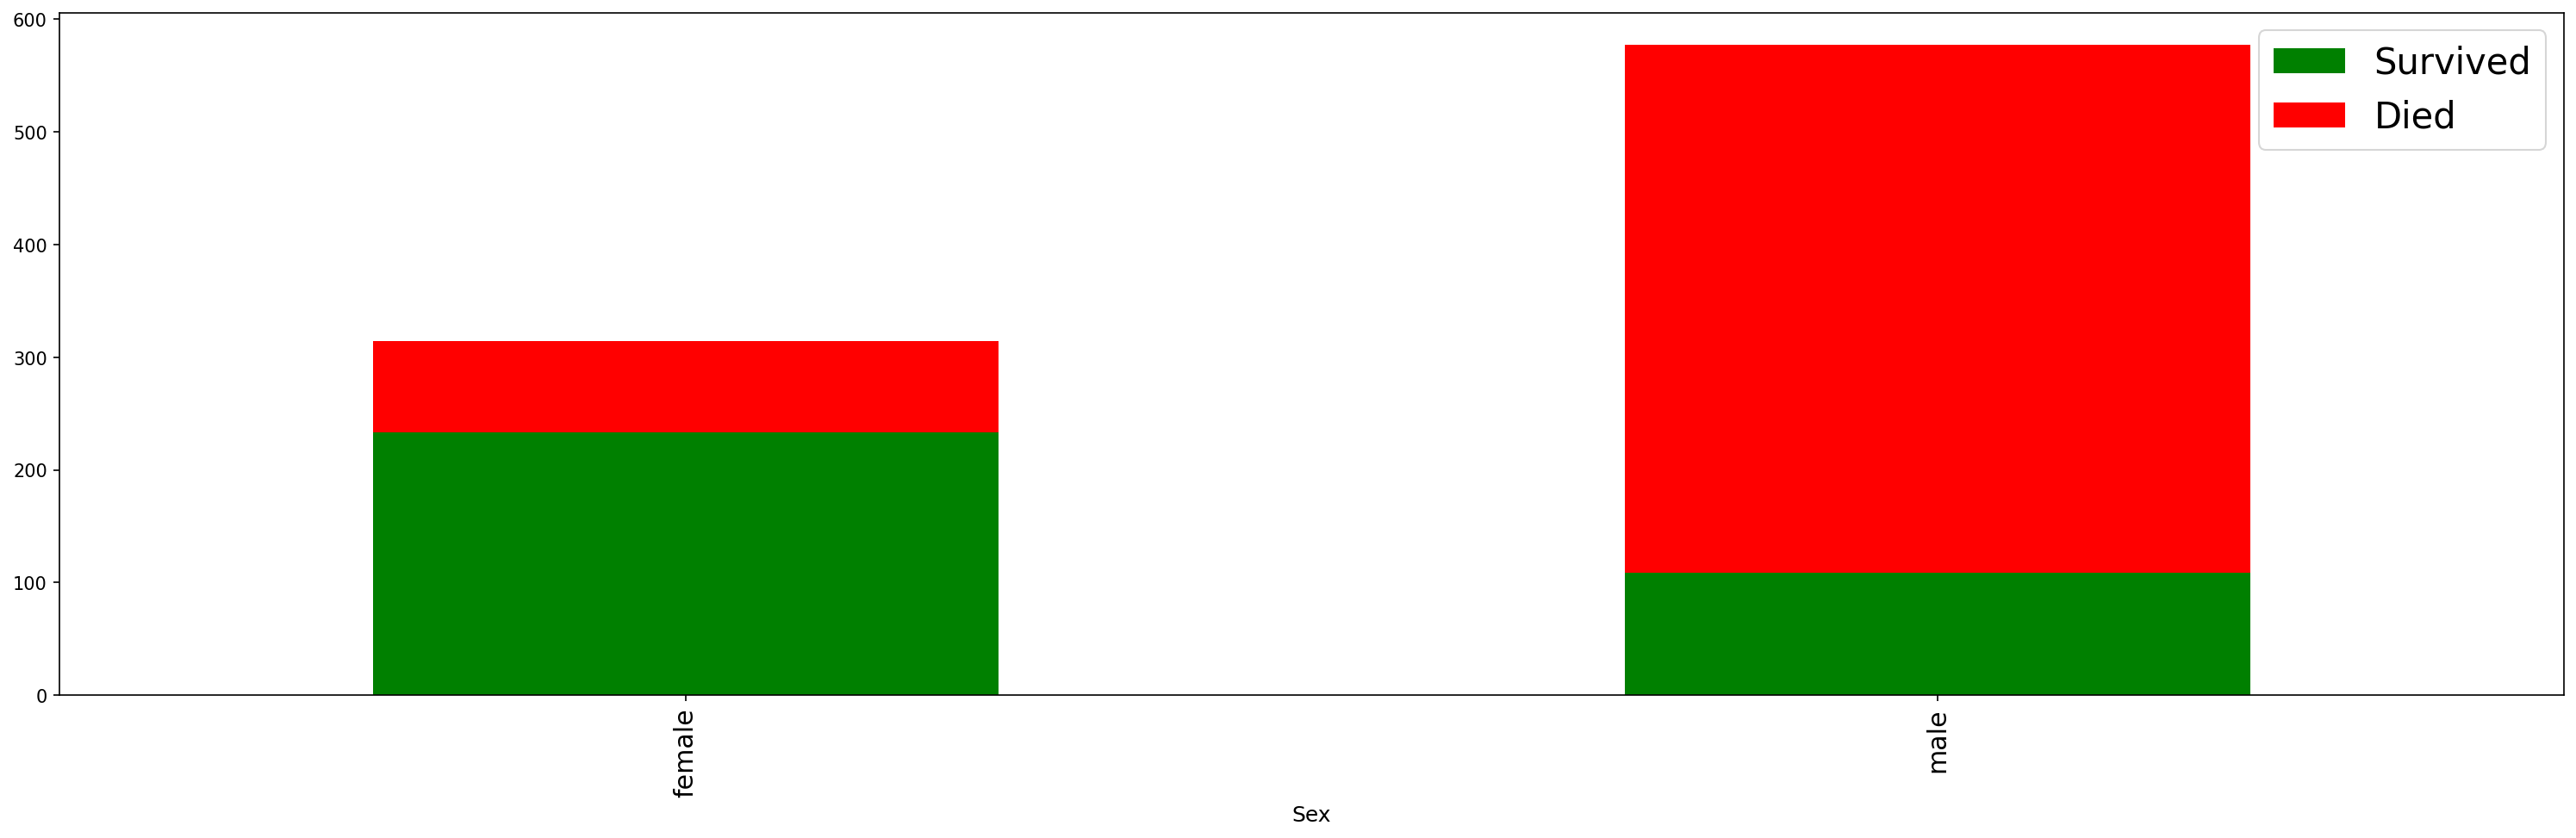

In [ ]:
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), stacked=True, color=['g', 'r'])

Bingo ! Parece que a variável sexo é uma feature discriminante. Mulheres tem mais chance de sobreviver.

Agora vamos tentar achar uma correlação entre sobrevivência e idade.

Nesse caso, utilizar um gráfico de violino pode ser mais interessante.

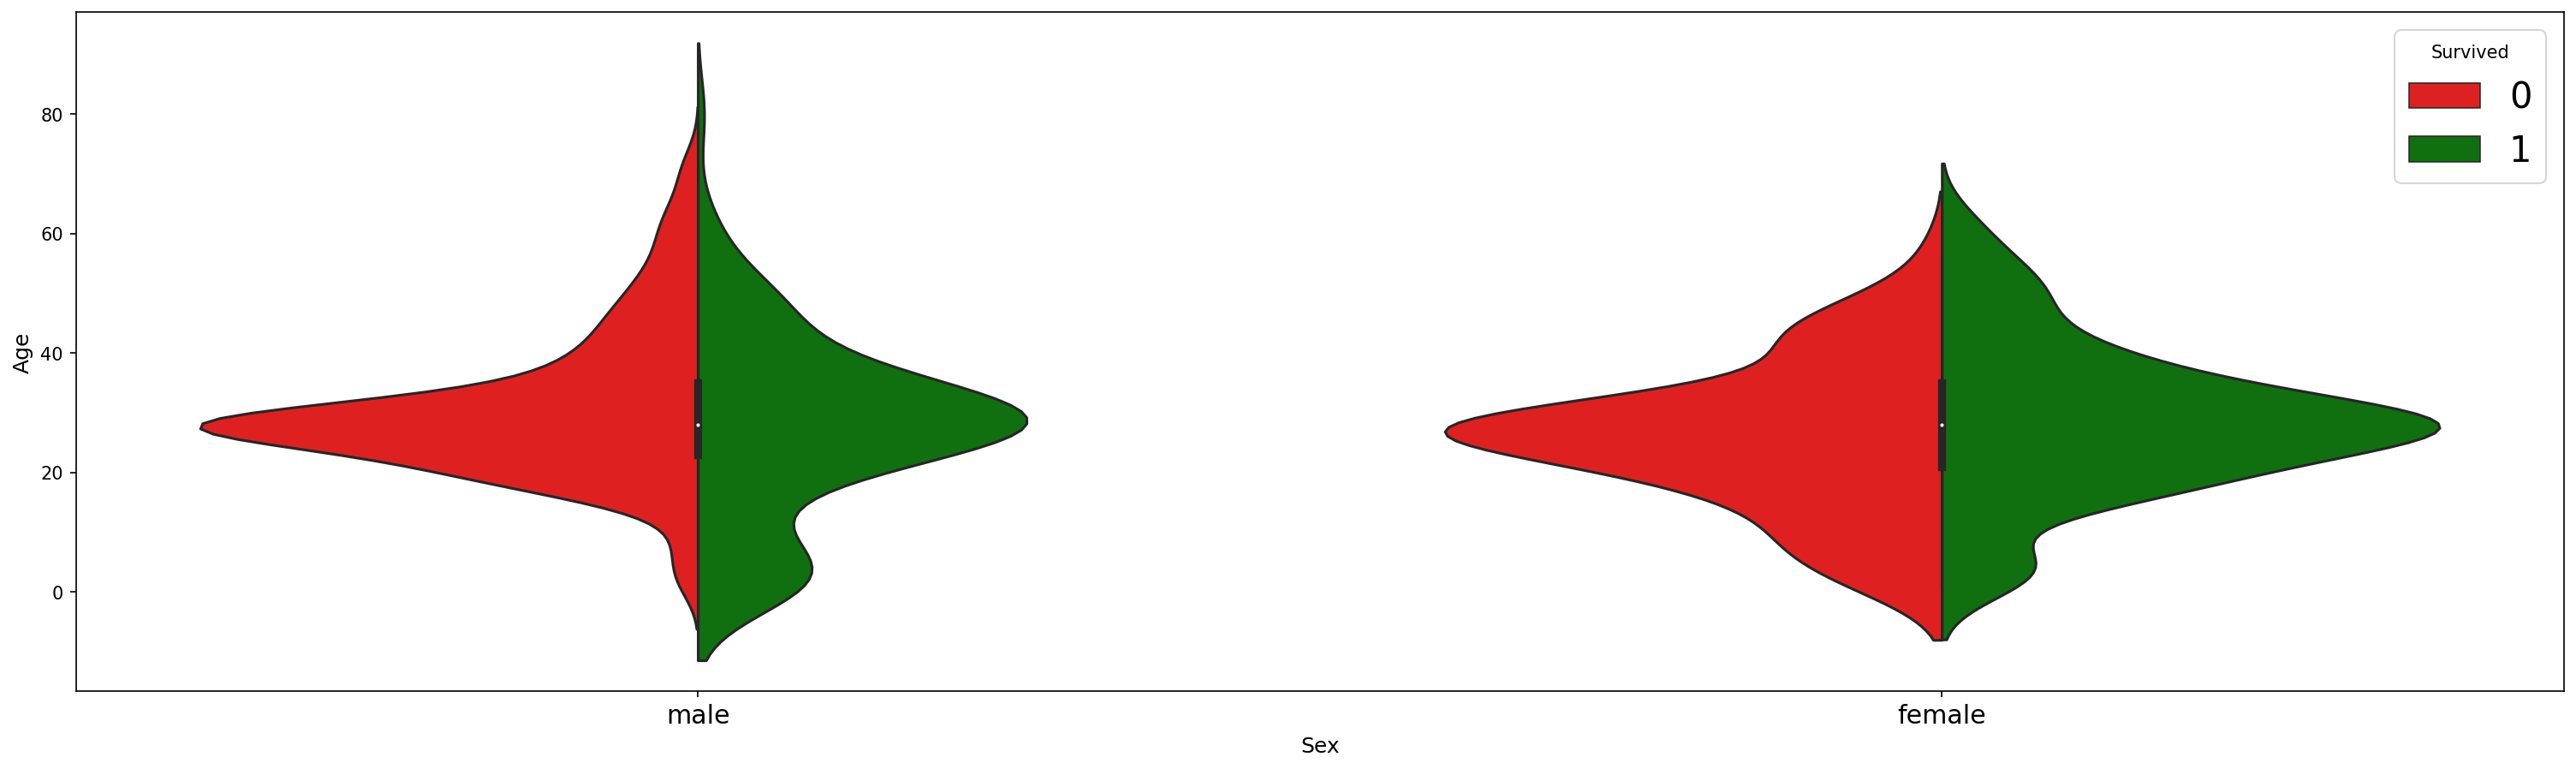

In [ ]:
fig = plt.figure(figsize=(25, 7))

sns.violinplot(x='Sex', y='Age', hue='Survived', data=data, split=True, palette={0: 'r', 1: 'g'})

Analise os gráfico acima e perceba:

Mulheres sobrevivem mais que homens, como percebido pelo histograma verde feminino maior.
Agora vamos analisar a idade:

Para passageiros homens:
Homens jovens tendem a sobreviver.
Um grande número de passageiros entre 20 e 40 anos morreram.
A idade não parece ter um impacto direto na sobrevivência de mulheres.

Esse gráfico de violina confirma um velho código de conduta de marinheiros e capitães em situações do tipo **"Mulheres e crianças primeiro!"**

Agora vamos focar na tarifa do ticket de cada passageiro e ver como ele impacta na sobrevivência.

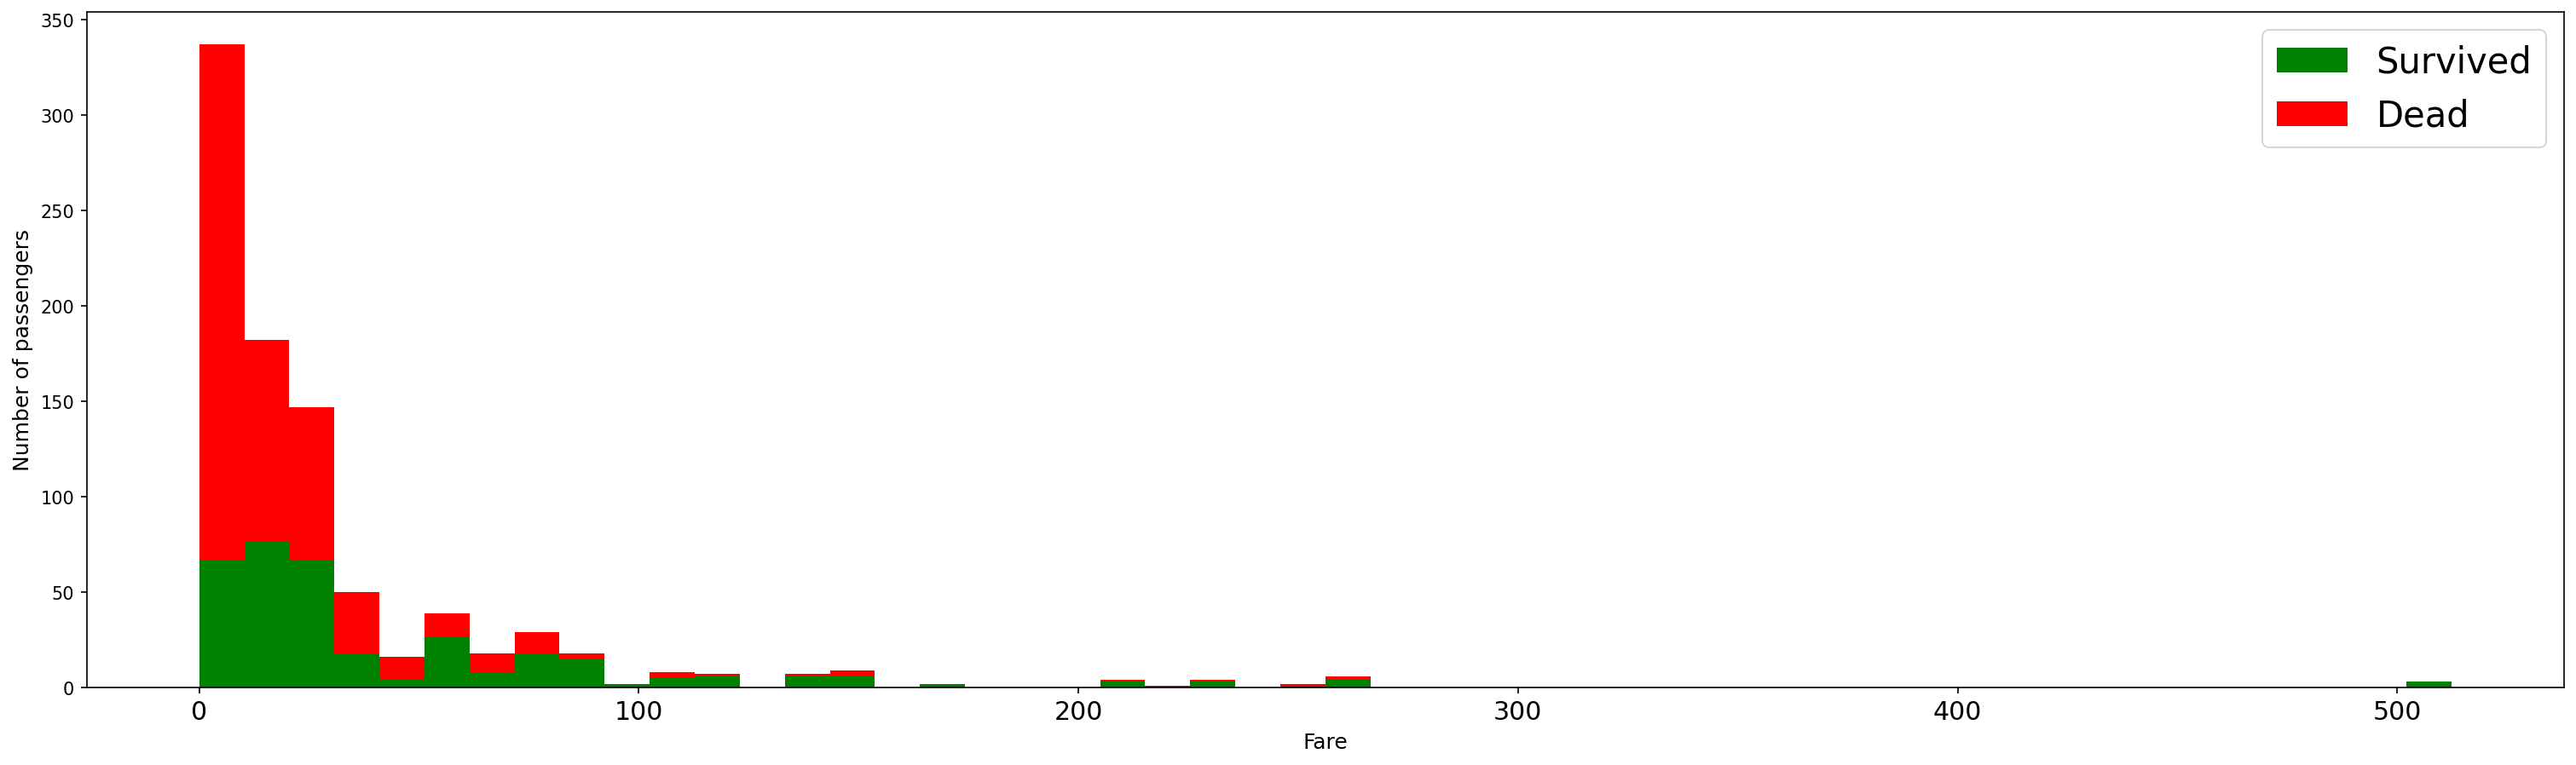

In [ ]:
figure = plt.figure(figsize=(25, 7))

plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']],
          stacked=True, color = ['g', 'r'], bins = 50, label = ['Survived', 'Dead']
        )

plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

Passageiros com tickets mais baratos tem mais chance de morrer. Colocado de outra forma, passageiros com tickets mais caros e com maior status social, parecm ser resgatados primeiro.

Legal ! Agora vamos combinar a idade, a tarifa e a sobrevivência em um único gráfico.

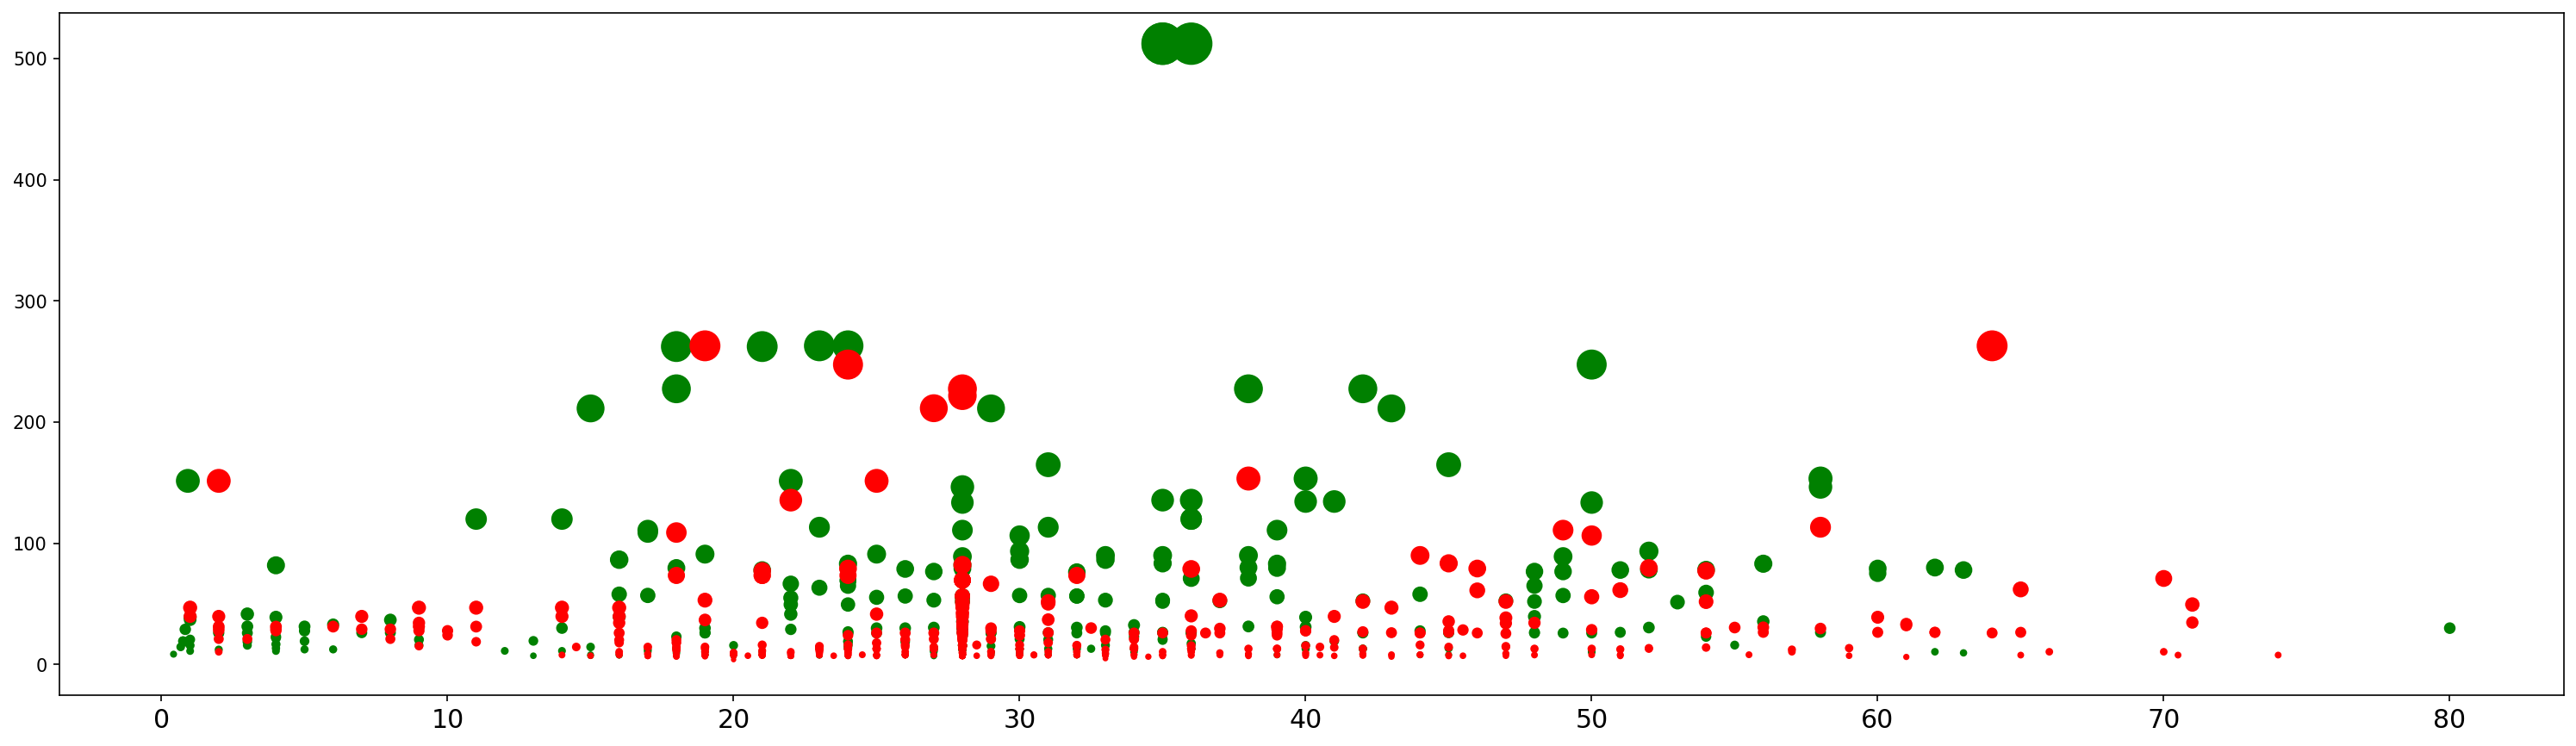

In [ ]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], c='red', s=data[data['Survived'] == 0]['Fare'])

O tamanho dos círculos é proporcional à tarifa da passagem.

No eixo x, temos as idades e no eixo y, consideramos a tarifa da passagem.

Podemos observar diferentes clusters:

  1. Grandes pontos verdes entre x = 20 e x = 45: adultos com as maiores tarifas
  2. Pequenos pontos vermelhos entre x = 10 e x = 45, adultos de classes mais baixas no barco
  3. Pequenos pontos de ganância entre x = 0 e x = 7: essas são as crianças que foram salvas

Na verdade, a tarifa do bilhete se correlaciona com a classe, como vemos no gráfico abaixo.

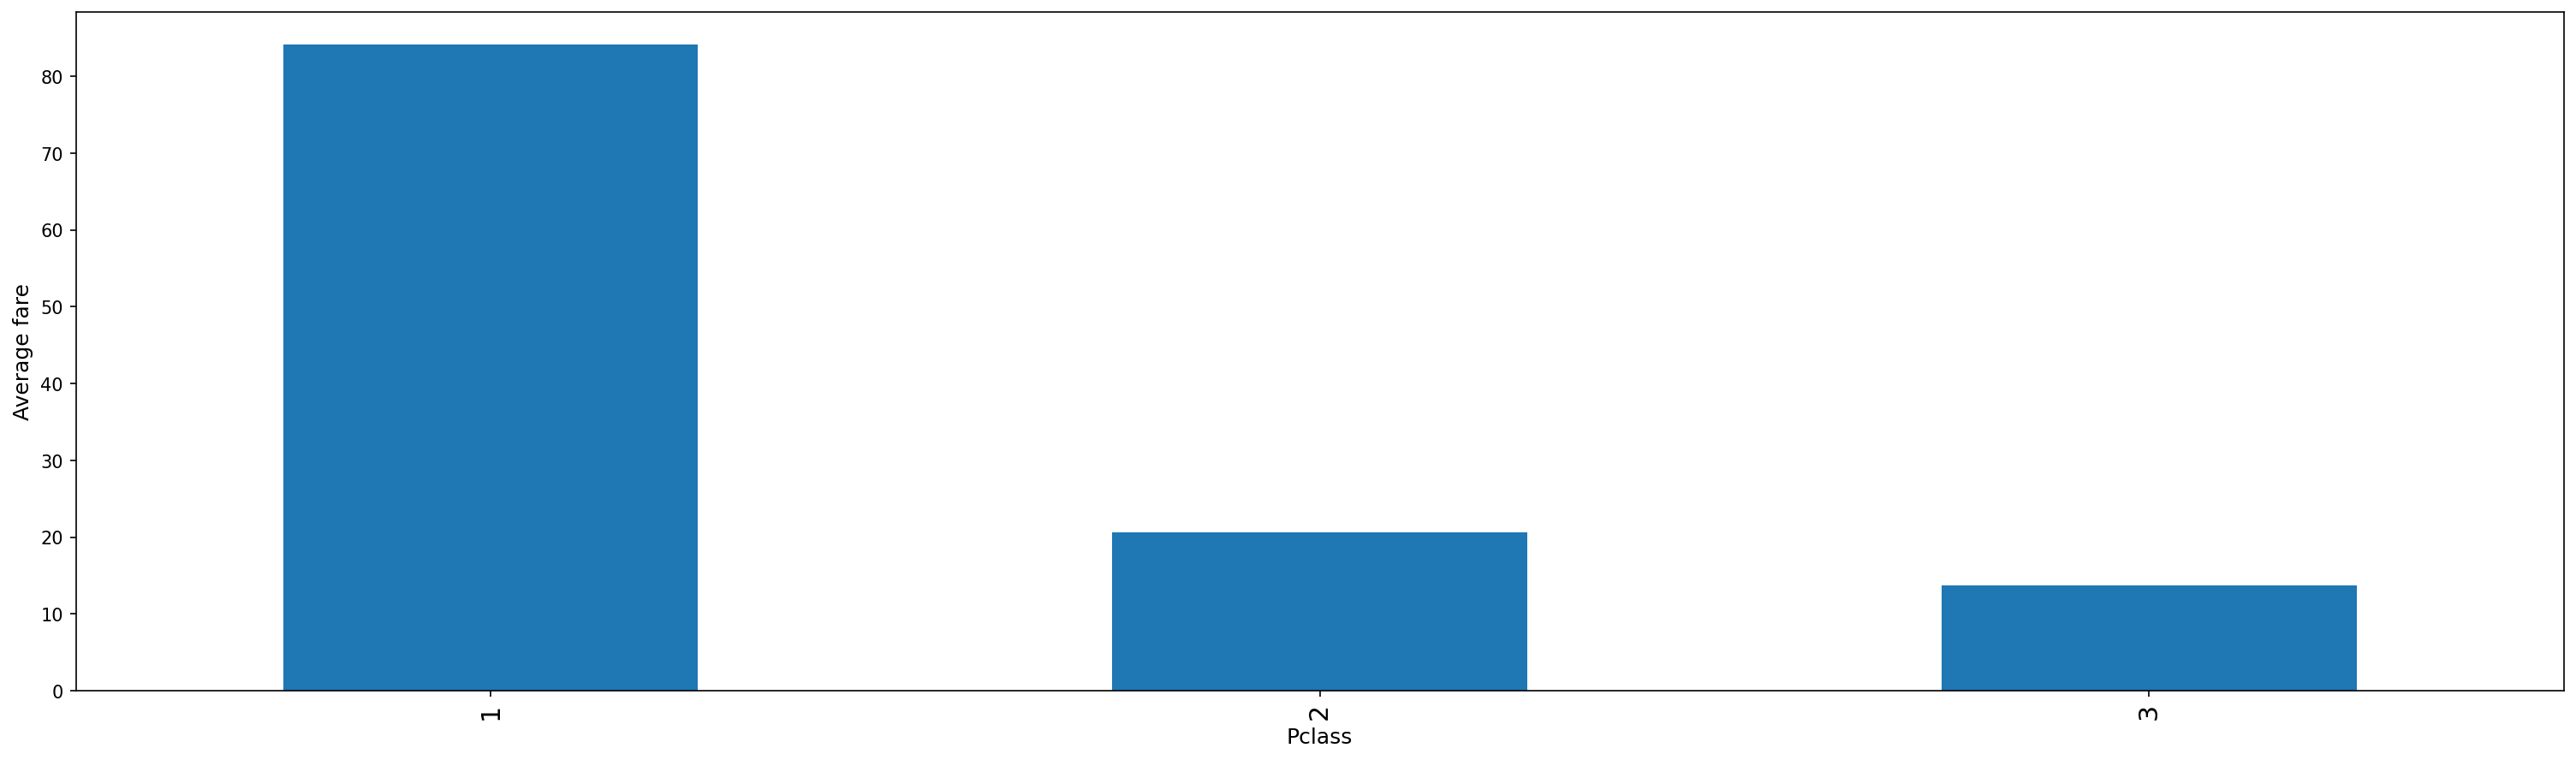

In [ ]:
ax = plt.subplot()

ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax)

Vamos ver como o porto de embarque afeta a sobrevivência.

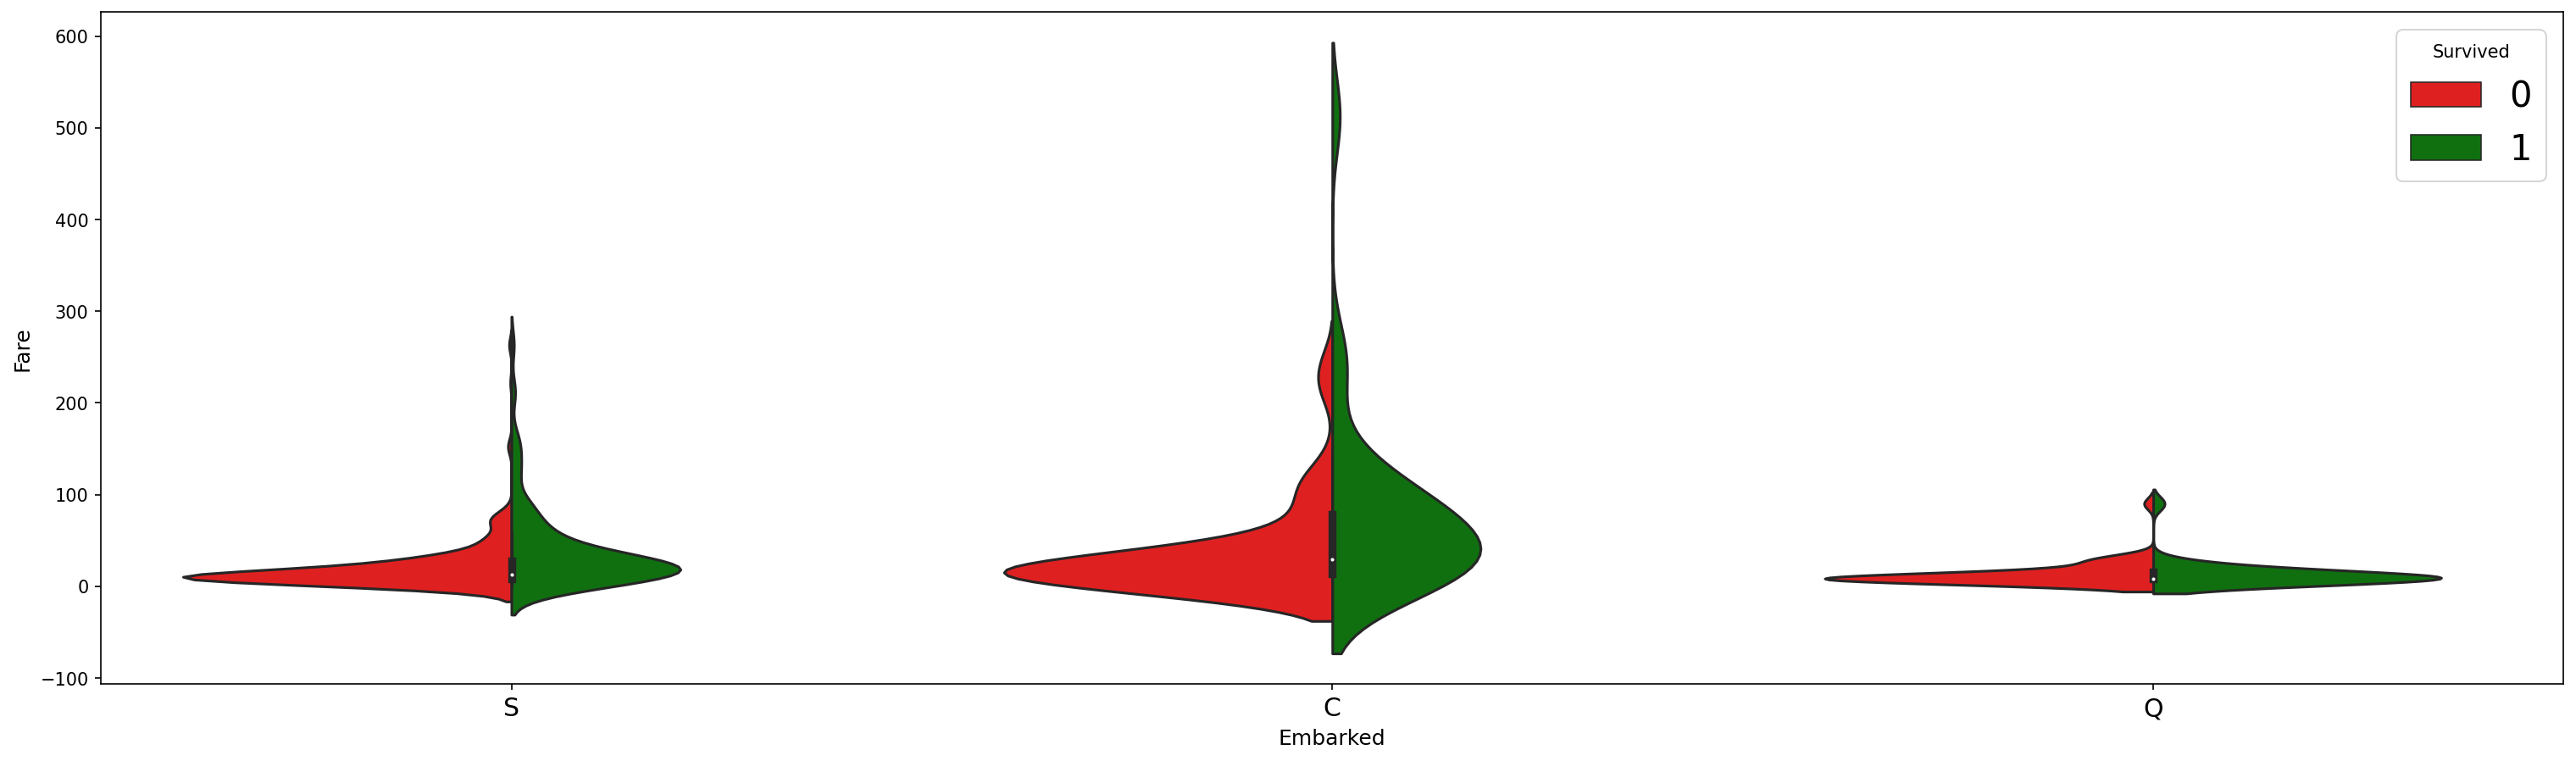

In [ ]:
fig = plt.figure(figsize=(25, 7))

sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data, split=True, palette={0: 'r', 1: 'g'})

Parece que o embarque em C tem uma gama maior de passagens e, portanto, os passageiros que pagam os preços mais altos são os que sobrevivem.

Também vemos isso acontecendo na embarcação S e menos na embarque Q.

Agora vamos parar com a exploração de dados e passar para a próxima parte.

# II - Feature engineering

Na parte anterior, nós exploramos um pouco os dados e descobrimos algumas correlações interessantes.

Nessa parte, veremos como processar e transformar essas correlações de forma que elas se tornem dados que podem ser manipulados por um algoritmo de machine learning.

Também criaremos ou "projetaremos" recursos adicionais que serão úteis na construção do modelo.

Veremos ao longo do caminho como processar variáveis ​​de texto como os nomes dos passageiros e integrar essas informações em nosso modelo.

Vamos dividir nosso código em funções separadas para maior clareza.

Mas primeiro, vamos definir uma função de print que afirma se um recurso foi ou não processado.

In [ ]:
def status(feature):
    print('Processing', feature, ': ok')

### Carregando os dados

Um truque ao iniciar um problema de machine learning é anexar o conjunto de treinamento ao conjunto de teste.

Vamos projetar novos recursos usando o conjunto de treino para evitar falha de informações. Em seguida, adicionaremos essas variáveis ​​ao conjunto de teste.

Vamos carregar os sets de treinamento e de testes e anexá-los juntos.

In [ ]:
def get_combined_data():
    # reading train data
    train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
    
    # reading test data
    test = pd.read_csv(io.BytesIO(uploaded['test.csv']))

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    

    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
    
    return combined

In [ ]:
combined = get_combined_data()

Vamos dar uma olhada no shape dos dados:

In [ ]:
print(combined.shape)

(1309, 10)


Os sets de treinamento e de testes foram combinados.

Você perceberá que o total de linhas (1309) é exatamente a somatória do número de linhas do set de treinamento com o set de testes.

In [ ]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Extraíndo os títulos dos passageiros (Titles)

Ao olhar para os nomes dos passageiros, pode-se imaginar como processá-los para extrair informações úteis.

Se você olhar atentamente para estes primeiros exemplos:

* Braund,** Mr. Owen** Harris
* Heikkinen, **Miss.** Laina
* Oliva y Ocana, **Dona.** Fermina
* Peter, **Master.** Michael J

Você notará que cada nome tem um título! Pode ser uma simples senhorita ou senhora, mas às vezes pode ser algo mais sofisticado como Mestre, Senhor ou Dona. Nesse caso, podemos apresentar uma informação adicional sobre o status social simplesmente analisando o nome e extraindo o título e convertendo em uma variável binária.

Vamos ver como faremos isso na função abaixo.


Vamos ver quais são os diferentes títulos no conjunto de treino.

In [ ]:
titles = set()

for name in data['Name']:
  titles.add(name.split(',')[1].split('.')[0].strip())

In [ ]:
print(titles)

{'Dr', 'Capt', 'Don', 'Mr', 'Ms', 'Master', 'Mlle', 'Col', 'Jonkheer', 'Sir', 'Miss', 'Major', 'Lady', 'Mrs', 'the Countess', 'Rev', 'Mme'}


In [ ]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
  combined['Title'] = combined['Name'].map(lambda name: name.split(',')[1].split('.')[0].strip())

  combined['Title'] = combined.Title.map(Title_Dictionary)
  status('Title')
  
  return combined

Esta função analisa os nomes e extrai os títulos. Em seguida, ele mapeia os títulos para categorias de títulos. Selecionamos:

* Officer
* Royalty
* Mr
* Mrs
* Miss
* Master

Vamos rodar.

In [ ]:
combined = get_titles()

Processing Title : ok


In [ ]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Vamos checar se todos os títulos foram preenchidos corretamente.

In [ ]:
combined[combined['Title'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,NaN


De fato, há um valor NaN na linha 1305. Na verdade, o nome correspondente é Oliva y Ocana, Dona. Fermina.

Este título não foi encontrado no conjunto de dados de treino.

Perfeito. Agora temos uma coluna adicional chamada 'Title' que contém informação relevante.

### Processando as idades (Age)

Vimos na primeira parte que faltavam 177 valores na variável Idade. Este é um número grande (~ 13% do conjunto de dados). Simplesmente substituí-los pela média ou mediana de idade pode não ser a melhor solução, pois a idade pode diferir por grupos e categorias de passageiros.

Para entender por que, vamos agrupar nosso conjunto de dados por sexo, título e classe de passageiro e, para cada subconjunto, calcular a idade média.

Para evitar o vazamento de dados do conjunto de teste, preenchemos as idades ausentes no trem usando o conjunto de trem e preenchemos as idades no conjunto de teste usando valores calculados também do conjunto de treino.


Número de idades ausentes no conjunto de treino

In [ ]:
print(combined.iloc[:891].Age.isnull().sum())

177


Número de idades ausentes no conjunto de teste

In [ ]:
print(combined.iloc[891:].Age.isnull().sum())

86


In [ ]:
grouped_train = combined.iloc[:891].groupby(['Sex', 'Pclass', 'Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [ ]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


Este dataframe nos ajudará a imputar valores de idade ausentes com base em critérios diferentes.

Observe a coluna de idade mediana e veja como esse valor pode ser diferente com base em Sex, Class e Title juntos.

Por exemplo:

* Se a passageira for mulher, da Pclass 1 e da realeza, a idade média é 40.5.
* Se o passageiro for homem, da Pclass 3, com título de Sr., a idade média é 26.

Vamos criar uma função que preencha a idade ausente em combinação com base nesses diferentes atributos.

In [ ]:
def fill_age(row):
  condition = (
    (grouped_median_train['Sex'] == row['Sex']) & 
    (grouped_median_train['Title'] == row['Title']) & 
    (grouped_median_train['Pclass'] == row['Pclass'])
  )
  return grouped_median_train[condition]['Age'].values[0]


def process_age():
  global combined
  # lambda é um for que executa um if ternário 
  combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
  status('Age')
  return combined

In [ ]:
combined = process_age()

Processing Age : ok


Perfeito. As idades que faltam foram substituídas.

No entanto, notamos um valor ausente em Fare, dois valores ausentes em Embarked e muitos valores ausentes em Cabin. Voltaremos a essas variáveis ​​mais tarde.

Vamos agora processar os nomes.

In [ ]:
def process_names():
    global combined
    # we clean the Name variable
    combined.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # removing the title variable
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

Esta função elimina a coluna Nome, pois não a usaremos mais porque criamos uma coluna Title.

Em seguida, codificamos os valores do título usando uma codificação dummy.

Você pode aprender sobre codificação dummy e como fazê-lo facilmente no Pandas aqui.

In [ ]:
combined = process_names()

Processing names : ok


In [ ]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


Como você pode ver :

* não há mais um recurso de nome.
* novas variáveis ​​(Title_X) apareceram. Esses recursos são binários.
  * Por exemplo, Se Title_Mr = 1, o Título correspondente é Mr.

### Processando as tarifas (Fare)

Vamos imputar o valor da tarifa ausente pela tarifa média calculada no conjunto de treino

In [ ]:
def process_fares():
    global combined
    # there's one missing fare value - replacing it with the mean.
    combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return combined

Esta função simplesmente substitui um valor de tarifa ausente pela média

In [ ]:
combined = process_fares()

Processing fare : ok


### Processando os Embarques (Embarked)

In [ ]:
def process_embarked():
    global combined
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    combined.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return combined

Esta função substitui os dois valores ausentes de Embarked pelo valor Embarked mais frequente.

In [ ]:
combined = process_embarked()

Processing embarked : ok


In [ ]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


### Processando a Cabine (Cabin)

In [ ]:
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')

In [ ]:
print(train_cabin)

{'B', 'E', 'A', 'T', 'C', 'F', 'G', 'D', 'U'}


In [ ]:
print(test_cabin)

{'B', 'E', 'A', 'C', 'F', 'G', 'D', 'U'}


Não temos nenhuma carta de cabine no conjunto de teste que não esteja presente no conjunto de treino.

In [ ]:
def process_cabin():
    global combined    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return combined

Esta função substitui os valores NaN por U (para Desconhecido). Em seguida, mapeia cada valor de Cabine para a primeira letra. Em seguida, ele codifica os valores da cabine usando a codificação dummy novamente.

In [ ]:
combined = process_cabin()

Processing cabin : ok


Ok, sem valores ausentes agora.

In [ ]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


### Processando o Sexo (Sex)

In [ ]:
def process_sex():
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    status('Sex')
    return combined

Esta função mapeia os valores de string masculino e feminino para 1 e 0, respectivamente.

In [ ]:
combined = process_sex()

Processing Sex : ok


### Processando a Classe (PClass)

In [ ]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return combined

Esta função codifica os valores de Pclass (1,2,3) usando uma codificação dummy.


In [ ]:
combined = process_pclass()

Processing Pclass : ok


In [ ]:
combined.head(20)

,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,0,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,0,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,1,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
5,1,26.0,0,0,330877,8.4583,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
6,1,54.0,0,0,17463,51.8625,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
7,1,2.0,3,1,349909,21.0750,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
8,0,27.0,0,2,347742,11.1333,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
9,0,14.0,1,0,237736,30.0708,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


### Processando o Bilhete (Ticket)

Vamos primeiro ver como os diferentes prefixos de tickets que temos em nosso conjunto de dados

In [ ]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

In [ ]:
tickets = set()
for t in combined['Ticket']:
    tickets.add(cleanTicket(t))

In [ ]:
print(len(tickets))

37


In [ ]:
def process_ticket():
    
    global combined
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

In [ ]:
combined = process_ticket()

Processing Ticket : ok


In [ ]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Processando a família (Family)

Esta parte inclui a criação de novas variáveis ​​com base no tamanho da família (o tamanho é, a propósito, outra variável que criamos).

Essa criação de novas variáveis ​​é feita sob uma suposição realista: famílias grandes são agrupadas, portanto, são mais propensas a serem resgatadas do que pessoas que viajam sozinhas.

In [ ]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined

Esta função apresenta 4 novos recursos:

* FamilySize: o número total de parentes incluindo o passageiro (ele / ela).
* Sigleton: uma variável booleana que descreve famílias de tamanho = 1
* SmallFamily: uma variável booleana que descreve famílias de 2 <= tamanho <= 4
* LargeFamily: uma variável booleana que descreve famílias de 5 < tamanho

In [ ]:
combined = process_family()

Processing family : ok


In [ ]:
print(combined.shape)

(1309, 67)


Acabamos com um total de 67 recursos.

In [ ]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


# III - Modelagem

Nesta parte, usamos nosso conhecimento dos passageiros com base nos recursos que criamos e, em seguida, construímos um modelo estatístico. Você pode pensar neste modelo como uma caixa que processa as informações de qualquer novo passageiro e decide se ele sobreviverá ou não.

Há uma grande variedade de modelos a serem usados, desde regressão logística até árvores de decisão e modelos mais sofisticados, como florestas aleatórias e árvores com aumento de gradiente.

Estaremos usando Random Forests. Random Froests provou ser uma grande eficiência nas competições Kaggle.

Para obter mais detalhes sobre por que os métodos de conjunto funcionam bem, você pode consultar estas postagens:

  * http://mlwave.com/kaggle-ensembling-guide/
  * http://www.overkillanalytics.net/more-is-always-better-the-power-of-simple-ensembles/

De volta ao nosso problema, agora temos que:

  1. Divida o conjunto de dados combinado em conjunto de trem e conjunto de teste.
  2. Use o conjunto de treinamento para construir um modelo preditivo.
  3. Avalie o modelo usando o conjunto de trem.
  4. Teste o modelo usando o conjunto de teste e gere um arquivo de saída para o envio.

Lembre-se de que teremos que repetir em 2. e 3. até que uma pontuação de avaliação aceitável seja alcançada.

Vamos começar importando as bibliotecas úteis.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

Para avaliar nosso modelo, usaremos uma validação cruzada de 5 vezes com a precisão, pois é a métrica que a concorrência usa na tabela de classificação.

Para fazer isso, vamos definir uma pequena função de pontuação.

In [ ]:
def compute_score(clf, X, y, scoring='accuracy'):
  xval = cross_val_score(clf, X, y, cv=5, scoring=scoring)
  return np.mean(xval)

Recuperar o conjunto de trem e o conjunto de teste do conjunto de dados combinado é uma tarefa fácil.

In [ ]:
def recover_train_test_target():
  global combined
  
  targets = pd.read_csv(io.BytesIO(uploaded['train.csv']), usecols=['Survived'])['Survived'].values
  train = combined.iloc[:891]
  test = combined.iloc[891:]

  return train, test, targets

In [ ]:
train, test, targets = recover_train_test_target()

### Seleção de recursos

Chegamos a mais de 30 recursos até agora. Esse número é muito grande.

Quando a engenharia de recursos é concluída, geralmente tendemos a diminuir a dimensionalidade selecionando o número "certo" de recursos que capturam o essencial.

Na verdade, a seleção de recursos traz muitos benefícios:

* Diminui a redundância entre os dados
* Acelera o processo de treinamento
* Reduz o overfitting

Estimadores baseados em árvore podem ser usados ​​para calcular importâncias de recursos, que por sua vez podem ser usados ​​para descartar recursos irrelevantes.

In [ ]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

Let's have a look at the importance of each feature.

In [ ]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

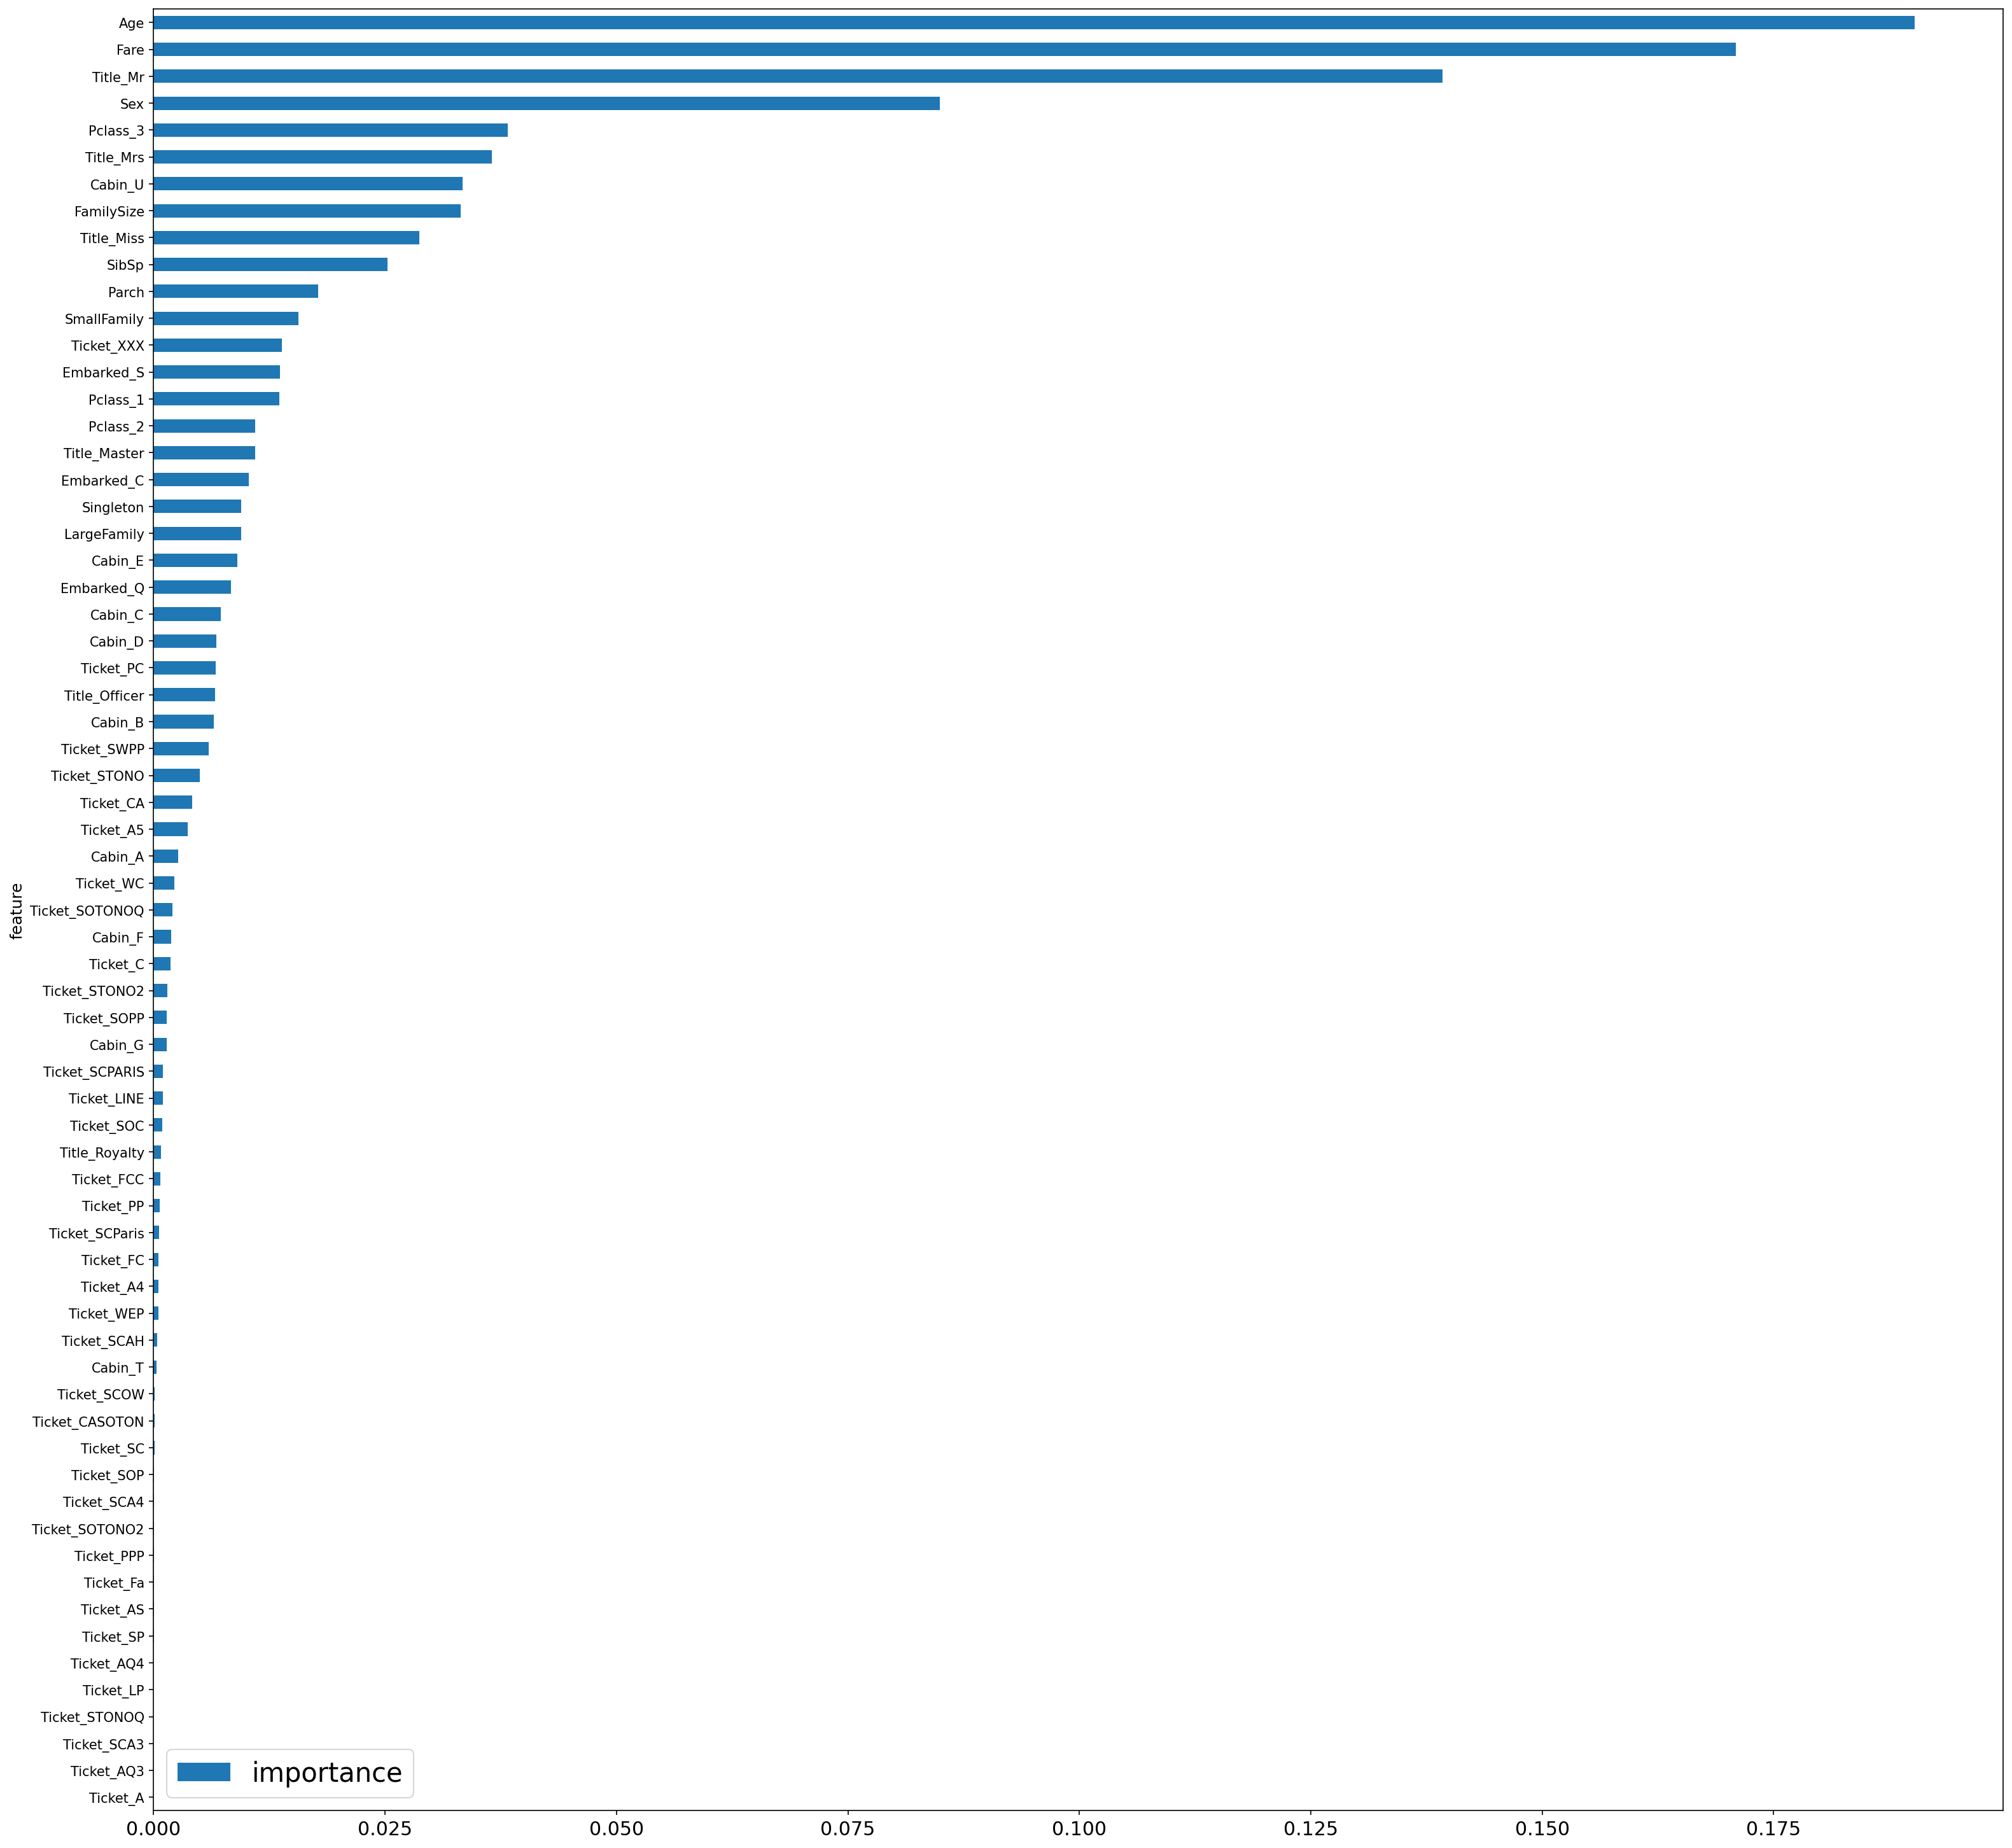

In [ ]:
features.plot(kind='barh', figsize=(25, 25))

Como você pode notar, há uma grande importância associada a Title_Mr, Age, Fare e Sex.

Também existe uma correlação importante com o Passenger_Id.

Vamos agora transformar nosso conjunto de treino e conjunto de teste em conjuntos de dados mais compactos.

In [ ]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)

(891, 12)


In [ ]:
test_reduced = model.transform(test)
print(test_reduced.shape)

(418, 12)


Yay! Agora temos muito menos recursos.

Veremos se usaremos a versão reduzida ou completa do conjunto de treino.

### Vamos tentar diferentes modelos básicos

In [ ]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

In [ ]:
for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')

Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8192894356914193
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV score = 0.8226602222082731
****
Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.8159500345238844
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8282656455966355
****


### Ajuste de hiperparâmetros

Conforme mencionado no início da parte de modelagem, estaremos usando um modelo de floresta aleatória. Pode não ser o melhor modelo para esta tarefa, mas mostraremos como ajustá-lo. Este trabalho pode ser aplicado a diferentes modelos.

Random Forest são bastante úteis. No entanto, eles vêm com alguns parâmetros a serem ajustados a fim de obter um modelo ideal para a tarefa de previsão.

Para aprender mais sobre Florestas Aleatórias, você pode consultar este
<a href="https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/">link </a>:

Além disso, usaremos o conjunto completo de treino.

In [ ]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = True

if run_gs:
    parameter_grid = {
                 'max_depth' : [8, 12, 16],
                 'n_estimators': [200, 40],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [5, 15, 50],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.8350260498399347
Best parameters: {'bootstrap': True, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 40}


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  4.4min finished


Agora que o modelo foi construído examinando várias combinações de hiperparâmetros, podemos gerar um arquivo de saída para enviar no Kaggle.

In [ ]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('minha_tentativa_6.csv', index=False)

### [Bonus] Blending different models

In [ ]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

In [ ]:
predictions_df.to_csv('blending_base_models.csv', index=False)

Para ter um bom envio de mesclagem, os modelos básicos devem ser diferentes e suas correlações não correlacionadas.

## IV - Conclusion